In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

# Reading images
import skimage.io
import skimage.transform
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow.python.framework import ops
from keras.preprocessing.image import ImageDataGenerator

import os

2024-06-26 19:39:08.427249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
artists = pd.read_csv('Downloads/Final Project/artists.csv')
artists.shape

(50, 8)

In [3]:
artists.head()

id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

In [4]:
artists.dtypes

id              int64
name           object
years          object
genre          object
nationality    object
bio            object
wikipedia      object
paintings       int64
dtype: object

In [5]:
artists.isna().sum() # no missing values in the csv

id             0
name           0
years          0
genre          0
nationality    0
bio            0
wikipedia      0
paintings      0
dtype: int64

In [6]:
artists.groupby("nationality").sum().reset_index().sort_values("paintings",ascending=False)

nationality   id  paintings
6                     French  388       2120
4                      Dutch   92       1360
15                   Spanish  105       1099
11                   Italian  225       1087
14                   Russian   31        484
5                    Flemish   64        356
9                     German   19        328
7             French,British   20        259
8   French,Jewish,Belarusian   22        239
0                   American   94        205
2                    Belgian    4        194
12                   Mexican   19        190
10              German,Swiss   42        188
1                   Austrian    9        117
16             Spanish,Greek   18         87
13                 Norwegian   37         67
3                    British   36         66

In [7]:
pd.DataFrame(artists.genre.value_counts()).reset_index().sort_values("index")

index  genre
30                   Abstract Expressionism      1
3                                   Baroque      4
10                            Byzantine Art      1
15                                   Cubism      1
21                        Early Renaissance      1
14                            Expressionism      1
9              Expressionism,Abstractionism      1
26  Expressionism,Abstractionism,Surrealism      1
5                          High Renaissance      3
23               High Renaissance,Mannerism      1
0                             Impressionism      4
8          Impressionism,Post-Impressionism      2
19                                Mannerism      1
27                            Neoplasticism      1
1                      Northern Renaissance      4
28                                  Pop Art      1
2                        Post-Impressionism      4
7                               Primitivism      2
20                   Primitivism,Surrealism      1
22                        Proto Renaissance      1
24                                  Realism      1
11                    Realism,Impressionism      1
4                               Romanticism      3
13                  Social Realism,Muralism      1
17                              Suprematism      1
6                                Surrealism      2
12                 Surrealism,Impressionism      1
16                                Symbolism      1
18                    Symbolism,Art Nouveau      1
25                  Symbolism,Expressionism      1
29             Symbolism,Post-Impressionism      1

In [8]:
artists2=artists.copy()


In [9]:
dct_genre={"Abstract Expressionism":"Expressionism","Surrealism,Impressionism":"Surrealism","Early Renaissance":"Renaissance","Expressionism,Abstractionism" :"Expressionism","Expressionism,Abstractionism,Surrealism":"Expressionism","High Renaissance":"Renaissance","High Renaissance,Mannerism":"Renaissance","Impressionism,Post-Impressionism":"Impressionism","Northern Renaissance":"Renaissance","Primitivism,Surrealism":"Primitivism","Proto Renaissance":"Renaissance","Realism,Impressionism":"Realism","Social Realism,Muralism":"Realism"," Symbolism,Art Nouveau":"Symbolism","Symbolism,Expressionism":"Symbolism","Symbolism,Post-Impressionism":"Symbolism","Symbolism,Art Nouveau":"Symbolism"}
artists2.genre=artists2.genre.map(dct_genre).fillna(artists2.genre)
pd.DataFrame(artists2.genre.value_counts()).reset_index().sort_values("index")

index  genre
5              Baroque      4
10       Byzantine Art      1
11              Cubism      1
3        Expressionism      4
1        Impressionism      6
13           Mannerism      1
14       Neoplasticism      1
15             Pop Art      1
2   Post-Impressionism      4
8          Primitivism      3
7              Realism      3
0          Renaissance     10
9          Romanticism      3
12         Suprematism      1
6           Surrealism      3
4            Symbolism      4

In [10]:
artists2.groupby('genre').sum().sort_values("paintings",ascending=False).reset_index()


genre   id  paintings
0        Impressionism  131       1647
1          Renaissance  279       1519
2   Post-Impressionism  120       1048
3            Symbolism  104        666
4              Baroque   97        586
5        Expressionism   92        493
6               Cubism   13        439
7           Surrealism   53        435
8          Primitivism   79        429
9          Romanticism   91        388
10             Realism   42        219
11             Pop Art   45        181
12         Suprematism   11        126
13       Byzantine Art    7         99
14           Mannerism   18         87
15       Neoplasticism   43         84

In [11]:
# Explore images of top artists
images_dir = 'Downloads/Final Project/images/images'
images_dir_2 = 'Downloads/Final Project/Trying'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists2['name'].str.replace(' ', '_').values
artists_top_genre = artists2['genre'].values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> Downloads/Final Project/images/images/Amedeo_Modigliani
Found --> Downloads/Final Project/images/images/Vasiliy_Kandinskiy
Found --> Downloads/Final Project/images/images/Diego_Rivera
Found --> Downloads/Final Project/images/images/Claude_Monet
Found --> Downloads/Final Project/images/images/Rene_Magritte
Found --> Downloads/Final Project/images/images/Salvador_Dali
Found --> Downloads/Final Project/images/images/Edouard_Manet
Found --> Downloads/Final Project/images/images/Andrei_Rublev
Found --> Downloads/Final Project/images/images/Vincent_van_Gogh
Found --> Downloads/Final Project/images/images/Gustav_Klimt
Found --> Downloads/Final Project/images/images/Hieronymus_Bosch
Found --> Downloads/Final Project/images/images/Kazimir_Malevich
Found --> Downloads/Final Project/images/images/Mikhail_Vrubel
Found --> Downloads/Final Project/images/images/Pablo_Picasso
Found --> Downloads/Final Project/images/images/Peter_Paul_Rubens
Found --> Downloads/Final Project/images/images/Pi

In [12]:
artists2.head()


id                name        years          genre nationality  \
0   0   Amedeo Modigliani  1884 - 1920  Expressionism     Italian   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism     Russian   
2   2        Diego Rivera  1886 - 1957        Realism     Mexican   
3   3        Claude Monet  1840 - 1926  Impressionism      French   
4   4       Rene Magritte  1898 - 1967     Surrealism     Belgian   

                                                 bio  \
0  Amedeo Clemente Modigliani (Italian pronunciat...   
1  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2  Diego María de la Concepción Juan Nepomuceno E...   
3  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

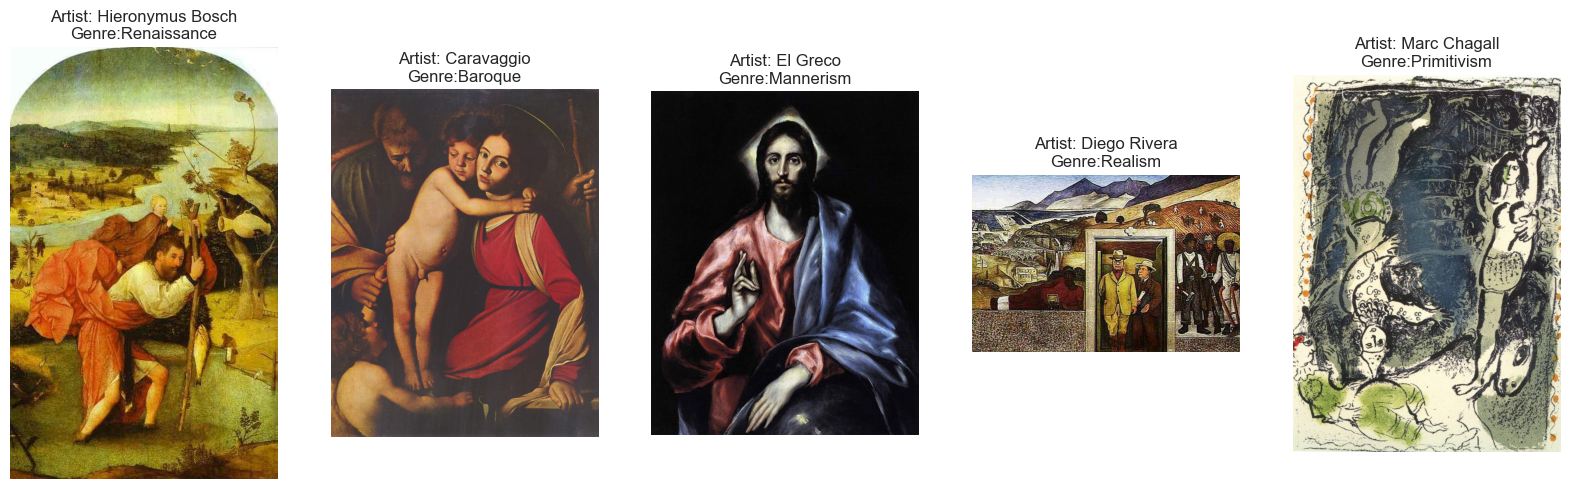

In [13]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    random_genre=' '.join([str(elem) for elem in list(artists2[artists.name.str.match(random_artist.replace('_', ' '))].genre)])
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' ')+"\n"+"Genre:"+random_genre)
    axes[i].axis('off')
plt.savefig('demo.png', transparent=True)
plt.show()

In [14]:
artists2=artists.copy()
dct_genre={"Abstract Expressionism":"Expressionism","Surrealism,Impressionism":"Surrealism","Early Renaissance":"Renaissance","Expressionism,Abstractionism" :"Expressionism","Expressionism,Abstractionism,Surrealism":"Expressionism","High Renaissance":"Renaissance","High Renaissance,Mannerism":"Renaissance","Impressionism,Post-Impressionism":"Impressionism","Northern Renaissance":"Renaissance","Primitivism,Surrealism":"Primitivism","Proto Renaissance":"Renaissance","Realism,Impressionism":"Realism","Social Realism,Muralism":"Realism"," Symbolism,Art Nouveau":"Symbolism","Symbolism,Expressionism":"Symbolism","Symbolism,Post-Impressionism":"Symbolism","Symbolism,Art Nouveau":"Symbolism"}
artists2.genre=artists2.genre.map(dct_genre).fillna(artists2.genre)
pd.DataFrame(artists2.genre.value_counts()).reset_index().sort_values("index")

index  genre
5              Baroque      4
10       Byzantine Art      1
11              Cubism      1
3        Expressionism      4
1        Impressionism      6
13           Mannerism      1
14       Neoplasticism      1
15             Pop Art      1
2   Post-Impressionism      4
8          Primitivism      3
7              Realism      3
0          Renaissance     10
9          Romanticism      3
12         Suprematism      1
6           Surrealism      3
4            Symbolism      4

In [15]:
artists2


id                       name        years               genre  \
0    0          Amedeo Modigliani  1884 - 1920       Expressionism   
1    1         Vasiliy Kandinskiy  1866 - 1944       Expressionism   
2    2               Diego Rivera  1886 - 1957             Realism   
3    3               Claude Monet  1840 - 1926       Impressionism   
4    4              Rene Magritte  1898 - 1967          Surrealism   
5    5              Salvador Dali  1904 - 1989          Surrealism   
6    6              Edouard Manet  1832 - 1883             Realism   
7    7              Andrei Rublev  1360 - 1430       Byzantine Art   
8    8           Vincent van Gogh  1853 – 1890  Post-Impressionism   
9    9               Gustav Klimt  1862 - 1918           Symbolism   
10  10           Hieronymus Bosch  1450 - 1516         Renaissance   
11  11           Kazimir Malevich  1879 - 1935         Suprematism   
12  12             Mikhail Vrubel  1856 - 1910           Symbolism   
13  13              Pablo Picasso  1881 - 1973              Cubism   
14  14          Peter Paul Rubens  1577 - 1640             Baroque   
15  15      Pierre-Auguste Renoir  1841 - 1919       Impressionism   
16  16             Francisco Goya  1746 - 1828         Romanticism   
17  17                Frida Kahlo  1907 - 1954         Primitivism   
18  18                   El Greco  1541 - 1614           Mannerism   
19  19             Albrecht Dürer  1471 - 1528         Renaissance   
20  20              Alfred Sisley  1839 - 1899       Impressionism   
21  21             Pieter Bruegel  1525 - 1569         Renaissance   
22  22               Marc Chagall  1887 - 1985         Primitivism   
23  23          Giotto di Bondone  1266 - 1337         Renaissance   
24  24          Sandro Botticelli  1445 - 1510         Renaissance   
25  25                 Caravaggio  1571 - 1610             Baroque   
26  26          Leonardo da Vinci  1452 - 1519         Renaissance   
27  27            Diego Velazquez  1599 - 1660             Baroque   
28  28              Henri Matisse  1869 - 1954       Impressionism   
29  29               Jan van Eyck  1395 - 1441         Renaissance   
30  30                Edgar Degas  1834 - 1917       Impressionism   
31  31                  Rembrandt  1606 - 1669             Baroque   
32  32                     Titian  1488 - 1576         Renaissance   
33  33  Henri de Toulouse-Lautrec  1864 – 1901  Post-Impressionism   
34  34            Gustave Courbet  1819 - 1877             Realism   
35  35           Camille Pissarro  1830 - 1903       Impressionism   
36  36             William Turner  1775 - 1851         Romanticism   
37  37               Edvard Munch  1863 - 1944           Symbolism   
38  38               Paul Cezanne  1839 – 1906  Post-Impressionism   
39  39           Eugene Delacroix  1798 – 1863         Romanticism   
40  40             Henri Rousseau  1844 – 1910         Primitivism   
41  41             Georges Seurat  1859 – 1891  Post-Impressionism   
42  42                  Paul Klee  1879 – 1940       Expressionism   
43  43              Piet Mondrian  1872 – 1944       Neoplasticism   
44  44                  Joan Miro  1893 – 1983          Surrealism   
45  45                Andy Warhol  1928 – 1987             Pop Art   
46  46               Paul Gauguin  1848 – 1903           Symbolism   
47  47                    Raphael  1483 – 1520         Renaissance   
48  48               Michelangelo  1475 – 1564         Renaissance   
49  49            Jackson Pollock  1912 – 1956       Expressionism   

                 nationality  \
0                    Italian   
1                    Russian   
2                    Mexican   
3                     French   
4                    Belgian   
5                    Spanish   
6                     French   
7                    Russian   
8                      Dutch   
9                   Austrian   
10                     Dutch   
11                   Russian   
12               

Text(0.5, 1.0, 'Genre representation over the top 50 artists')

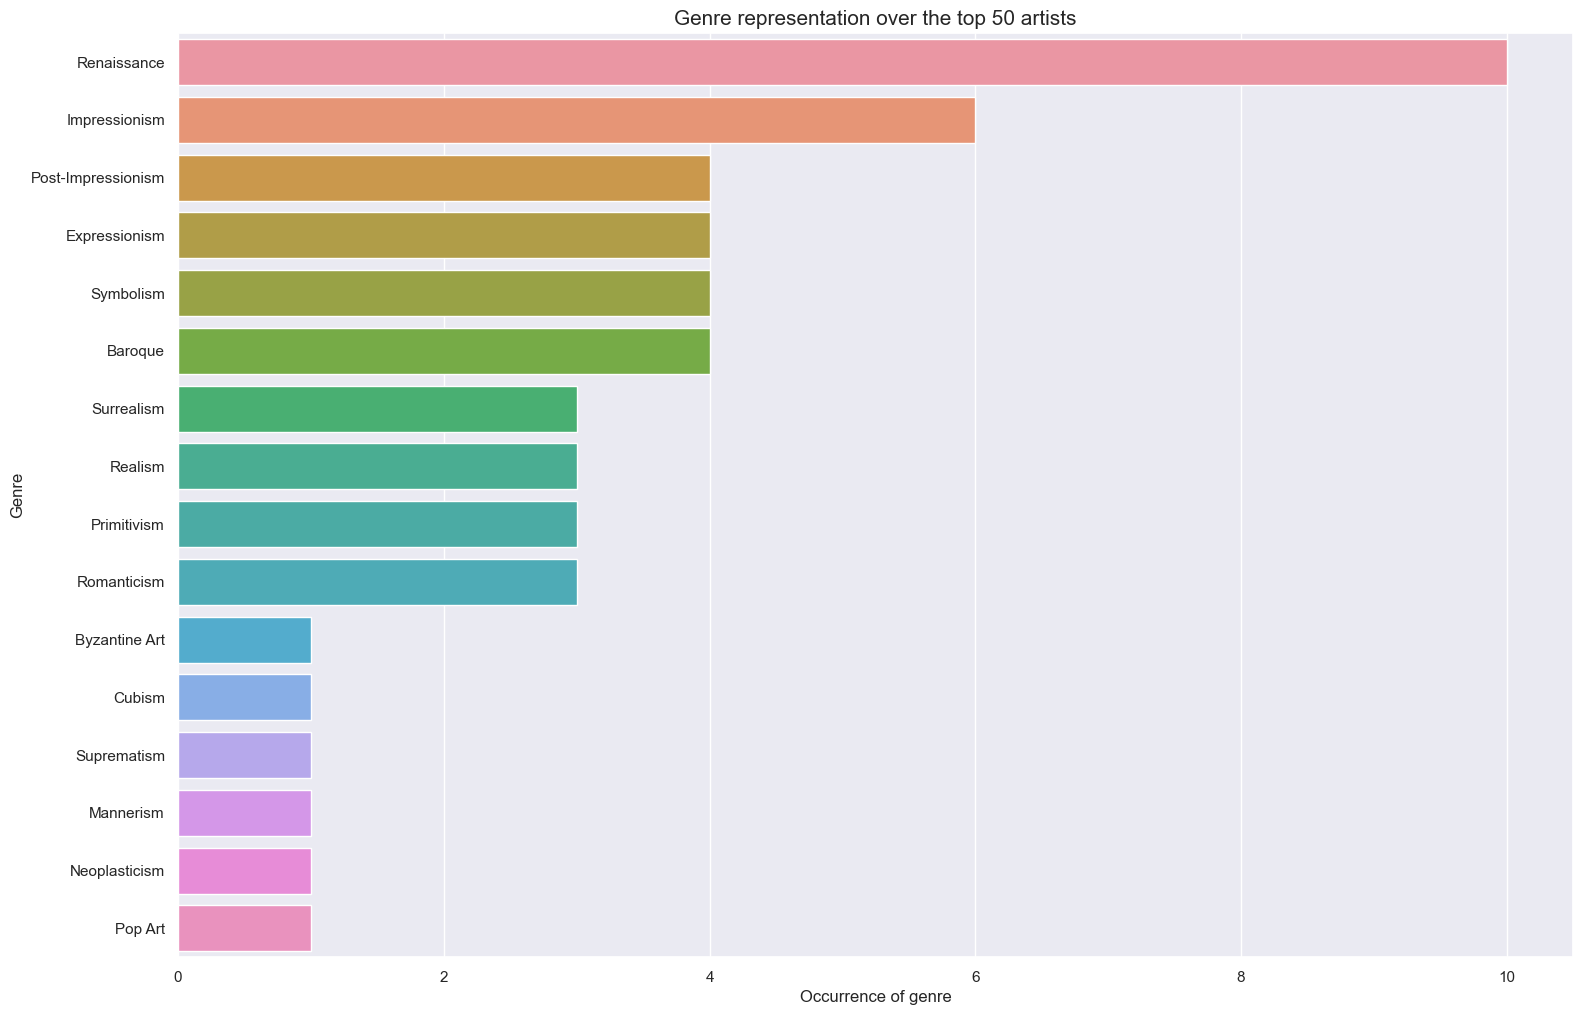

In [16]:
plt.figure(figsize=(18,12))
sns.barplot(data=pd.DataFrame(artists2.genre.value_counts()).reset_index(),y="index",x="genre",orient='h')
plt.ylabel("Genre")
plt.xlabel("Occurrence of genre")
#plt.xticks(rotation='vertical')
plt.title("Genre representation over the top 50 artists",fontsize=15)

In [17]:
artists2.groupby('genre').sum().sort_values("paintings",ascending=False).reset_index()


genre   id  paintings
0        Impressionism  131       1647
1          Renaissance  279       1519
2   Post-Impressionism  120       1048
3            Symbolism  104        666
4              Baroque   97        586
5        Expressionism   92        493
6               Cubism   13        439
7           Surrealism   53        435
8          Primitivism   79        429
9          Romanticism   91        388
10             Realism   42        219
11             Pop Art   45        181
12         Suprematism   11        126
13       Byzantine Art    7         99
14           Mannerism   18         87
15       Neoplasticism   43         84

Text(0.5, 1.0, 'Ranking of number of paintings per genre')

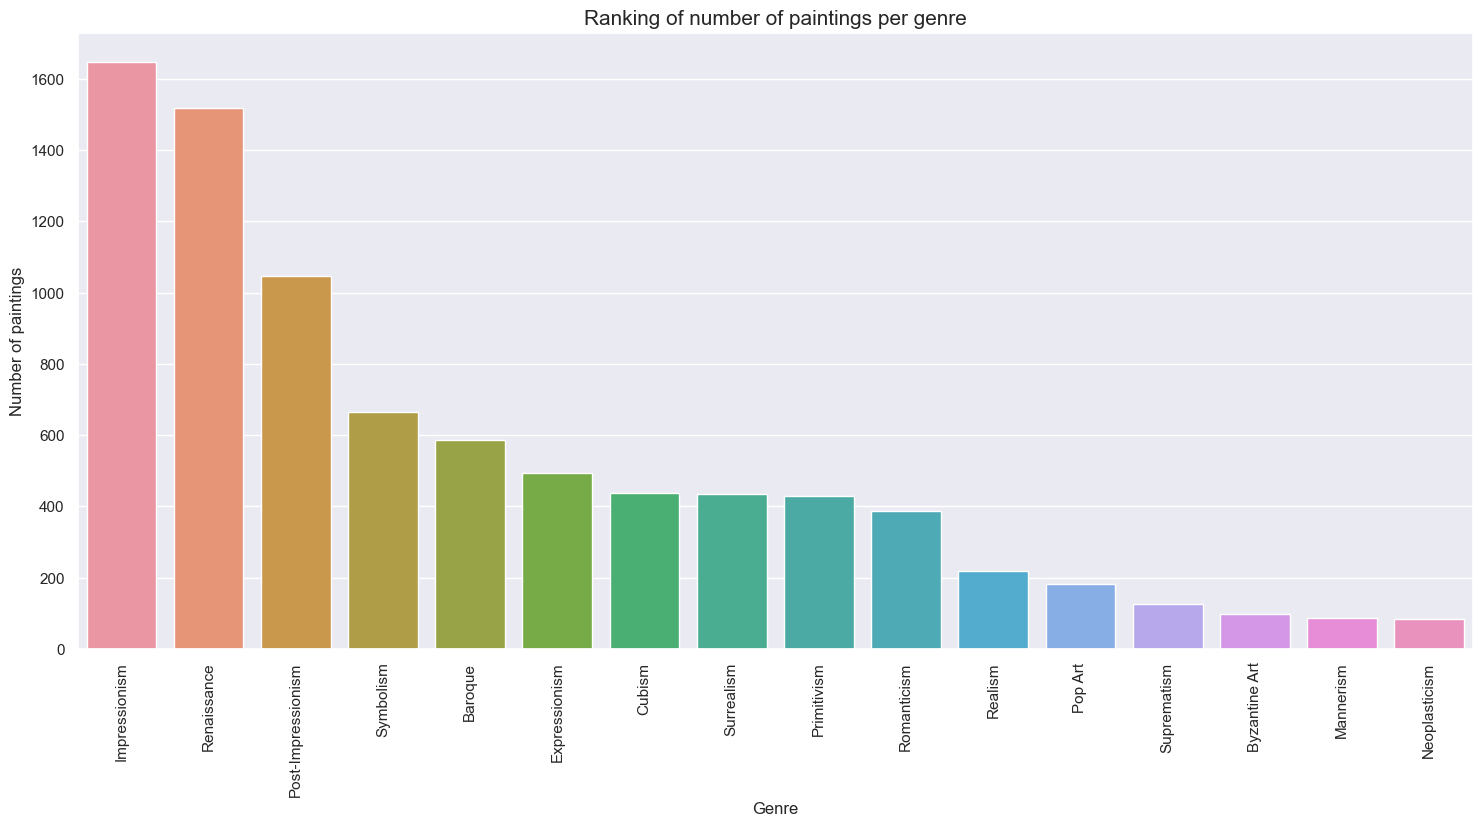

In [18]:
plt.figure(figsize=(18,8))
sns.barplot(data=artists2.groupby('genre').sum().sort_values("paintings",ascending=False).reset_index(),x="genre",y="paintings")
plt.xlabel("Genre")
plt.ylabel("Number of paintings")
plt.xticks(rotation='vertical')
plt.title("Ranking of number of paintings per genre",fontsize=15)

In [19]:
genre=list(artists2.genre.unique())
genre

['Expressionism',
 'Realism',
 'Impressionism',
 'Surrealism',
 'Byzantine Art',
 'Post-Impressionism',
 'Symbolism',
 'Renaissance',
 'Suprematism',
 'Cubism',
 'Baroque',
 'Romanticism',
 'Primitivism',
 'Mannerism',
 'Neoplasticism',
 'Pop Art']

In [20]:
artists2.loc[artists2.genre == "Renaissance"]


id               name        years        genre nationality  \
10  10   Hieronymus Bosch  1450 - 1516  Renaissance       Dutch   
19  19     Albrecht Dürer  1471 - 1528  Renaissance      German   
21  21     Pieter Bruegel  1525 - 1569  Renaissance     Flemish   
23  23  Giotto di Bondone  1266 - 1337  Renaissance     Italian   
24  24  Sandro Botticelli  1445 - 1510  Renaissance     Italian   
26  26  Leonardo da Vinci  1452 - 1519  Renaissance     Italian   
29  29       Jan van Eyck  1395 - 1441  Renaissance     Flemish   
32  32             Titian  1488 - 1576  Renaissance     Italian   
47  47            Raphael  1483 – 1520  Renaissance     Italian   
48  48       Michelangelo  1475 – 1564  Renaissance     Italian   

                                                  bio  \
10  Hieronymus Bosch ( (listen); Dutch: [ɦijeːˈroː...   
19  Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...   
21  Pieter Bruegel (also Brueghel) the Elder (Dutc...   
23  Giotto di Bondone (Italian pronunciation: [ˈdʒ...   
24  Alessandro (c. 1445 – May 17, 1510), known as ...   
26  Leonardo di ser Piero da Vinci (Italian: [leoˈ...   
29  Jan van Eyck (Dutch: [ˈjɑn vɑn ˈɛik]) (before ...   
32  Tiziano Vecelli or Tiziano Vecellio (pronounce...   
47  Raffaello Sanzio da Urbino (Italian: [raffaˈɛl...   
48  Michelangelo di Lodovico Buonarroti Simoni or ...   

                                            wikipedia  paintings  
10      http://en.wikipedia.org/wiki/Hieronymus_Bosch        137  
19        http://en.wikipedia.org/wiki/Albrecht_Dürer        328  
21  http://en.wikipedia.org/wiki/Pieter_Bruegel_th...        134  
23     http://en.wikipedia.org/wiki/Giotto_di_Bondone        119  
24     http://en.wikipedia.org/wiki/Sandro_Botticelli        164  
26     http://en.wikipedia.org/wiki/Leonardo_da_Vinci        143  
29          http://en.wikipedia.org/wiki/Jan_van_Eyck         81  
32                http://en.wikipedia.org/wiki/Titian        255  
47              https://en.wikipedia.org/wiki/Raphael        109  
48         https://en.wikipedia.org/wiki/Michelangelo         49

In [21]:
# Explore images of top artists
images_dir = 'Downloads/Final Project/images/images'
images_dir_2 = 'Downloads/Final Project/Trying'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists2['name'].str.replace(' ', '_').values
artists_top_genre = artists2['genre'].values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> Downloads/Final Project/images/images/Amedeo_Modigliani
Found --> Downloads/Final Project/images/images/Vasiliy_Kandinskiy
Found --> Downloads/Final Project/images/images/Diego_Rivera
Found --> Downloads/Final Project/images/images/Claude_Monet
Found --> Downloads/Final Project/images/images/Rene_Magritte
Found --> Downloads/Final Project/images/images/Salvador_Dali
Found --> Downloads/Final Project/images/images/Edouard_Manet
Found --> Downloads/Final Project/images/images/Andrei_Rublev
Found --> Downloads/Final Project/images/images/Vincent_van_Gogh
Found --> Downloads/Final Project/images/images/Gustav_Klimt
Found --> Downloads/Final Project/images/images/Hieronymus_Bosch
Found --> Downloads/Final Project/images/images/Kazimir_Malevich
Found --> Downloads/Final Project/images/images/Mikhail_Vrubel
Found --> Downloads/Final Project/images/images/Pablo_Picasso
Found --> Downloads/Final Project/images/images/Peter_Paul_Rubens
Found --> Downloads/Final Project/images/images/Pi

In [22]:
artists2.head()

id                name        years          genre nationality  \
0   0   Amedeo Modigliani  1884 - 1920  Expressionism     Italian   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism     Russian   
2   2        Diego Rivera  1886 - 1957        Realism     Mexican   
3   3        Claude Monet  1840 - 1926  Impressionism      French   
4   4       Rene Magritte  1898 - 1967     Surrealism     Belgian   

                                                 bio  \
0  Amedeo Clemente Modigliani (Italian pronunciat...   
1  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2  Diego María de la Concepción Juan Nepomuceno E...   
3  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

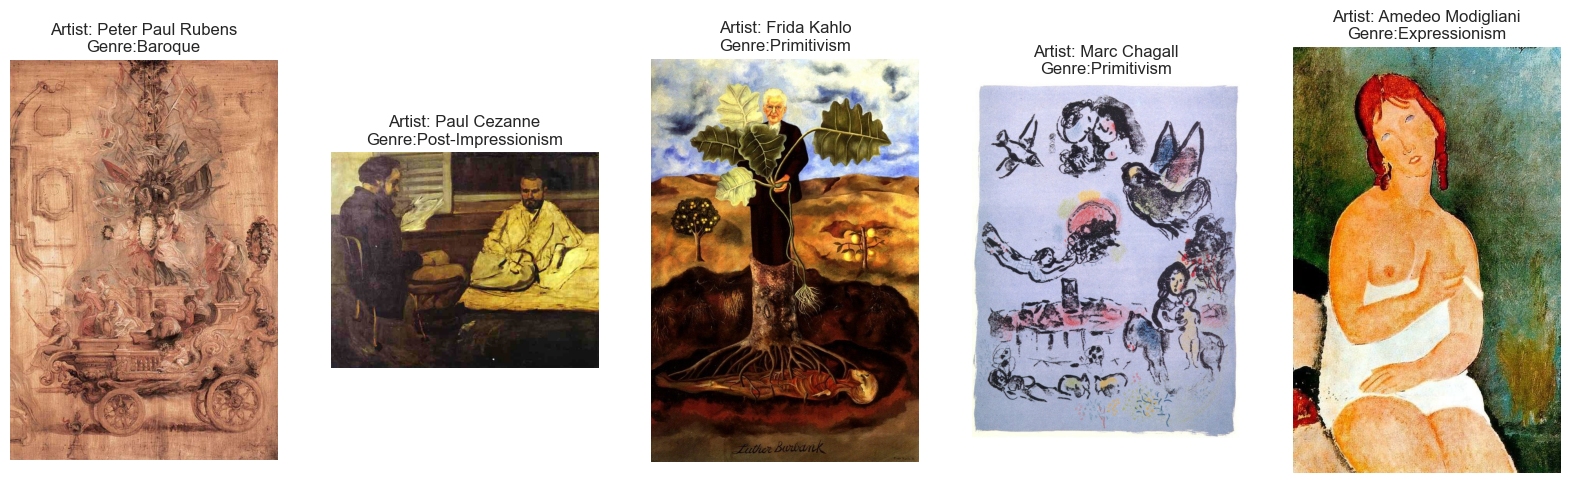

In [23]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    random_genre=' '.join([str(elem) for elem in list(artists2[artists.name.str.match(random_artist.replace('_', ' '))].genre)])
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' ')+"\n"+"Genre:"+random_genre)
    axes[i].axis('off')
plt.savefig('demo.png', transparent=True)
plt.show()

In [24]:
genre


['Expressionism',
 'Realism',
 'Impressionism',
 'Surrealism',
 'Byzantine Art',
 'Post-Impressionism',
 'Symbolism',
 'Renaissance',
 'Suprematism',
 'Cubism',
 'Baroque',
 'Romanticism',
 'Primitivism',
 'Mannerism',
 'Neoplasticism',
 'Pop Art']

In [25]:
dct_artist=dict(zip(artists_top_name.tolist(),list(artists2.genre)))


In [26]:
import os
from PIL import Image

# Define the source directory
source_dir = 'Downloads/Final Project/resized/resized'

# Define the destination directory (can be the same as the source directory or a different one)
dest_dir = 'Downloads/Final Project/resized/resized_resized_100'

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Iterate through the files in the source directory
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)
    
    # Check if the current file is an image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Load and resize the image
        img = Image.open(file_path)
        img_resized = img.resize((100, 100))
        
        # Save the resized image to the destination directory
        dest_file_path = os.path.join(dest_dir, filename)
        img_resized.save(dest_file_path)

        print(f'Resized and saved: {dest_file_path}')

Resized and saved: Downloads/Final Project/resized/resized_resized_100/Gustav_Klimt_113.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Vincent_van_Gogh_388.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Amedeo_Modigliani_24.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Edgar_Degas_455.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Edgar_Degas_333.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Joan_Miro_48.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Edgar_Degas_47.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Titian_232.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Leonardo_da_Vinci_19.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Pierre-Auguste_Renoir_138.jpg
Resized and saved: Downloads/Final Project/resized/resized_resized_100/Sa

In [27]:
from PIL import Image

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32")
    return data

In [28]:
import os
import shutil

# Define paths
source_dir = 'Downloads/Final Project/resized/resized_resized_100'
destination_dir = 'Downloads/Final Project/organized'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Define artist to time period mapping
artist_to_period = {
    "Amedeo_Modigliani": "Expressionism",
    "Vasiliy_Kandinskiy": "Expressionism",
    "Diego_Rivera": "Social Realism",
    "Claude_Monet": "Impressionism",
    "Rene_Magritte": "Surrealism",
    "Salvador_Dali": "Surrealism",
    "Edouard_Manet": "Realism",
    "Andrei_Rublev": "Byzantine Art",
    "Vincent_van_Gogh": "Post-Impressionism",
    "Gustav_Klimt": "Symbolism",
    "Hieronymus_Bosch": "Northern Renaissance",
    "Kazimir_Malevich": "Suprematism",
    "Mikhail_Vrubel": "Symbolism",
    "Pablo_Picasso": "Cubism",
    "Peter_Paul_Rubens": "Baroque",
    "Pierre-Auguste_Renoir": "Impressionism",
    "Francisco_Goya": "Romanticism",
    "Frida_Kahlo": "Primitivism",
    "El_Greco": "Mannerism",
    "Albrecht": "Northern Renaissance",
    "Alfred_Sisley": "Impressionism",
    "Pieter_Bruegel": "Northern Renaissance",
    "Marc_Chagall": "Primitivism",
    "Giotto_di_Bondone": "Proto Renaissance",
    "Sandro_Botticelli": "Early Renaissance",
    "Caravaggio": "Baroque",
    "Leonardo_da_Vinci": "High Renaissance",
    "Diego_Velazquez": "Baroque",
    "Henri_Matisse": "Impressionism",
    "Jan_van_Eyck": "Northern Renaissance",
    "Edgar_Degas": "Impressionism",
    "Rembrandt": "Baroque",
    "Titian": "High Renaissance",
    "Henri_de_Toulouse-Lautrec": "Post-Impressionism",
    "Gustave_Courbet": "Realism",
    "Camille_Pissarro": "Impressionism",
    "William_Turner": "Romanticism",
    "Edvard_Munch": "Symbolism",
    "Paul_Cezanne": "Post-Impressionism",
    "Eugene_Delacroix": "Romanticism",
    "Henri_Rousseau": "Primitivism",
    "Georges_Seurat": "Post-Impressionism",
    "Paul_Klee": "Expressionism",
    "Piet_Mondrian": "Neoplasticism",
    "Joan_Miro": "Surrealism",
    "Andy_Warhol": "Pop Art",
    "Paul_Gauguin": "Symbolism",
    "Raphael": "High Renaissance",
    "Michelangelo": "High Renaissance",
    "Jackson_Pollock": "Abstract Expressionism"
}

# Function to get the time period based on the artist's name in the filename
def get_time_period(filename):
    for artist, period in artist_to_period.items():
        if artist in filename:
            return period
    return None

# Iterate over all images in the source directory
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):  # Adjust file types as needed
            file_path = os.path.join(root, file)
            time_period = get_time_period(file)
            if time_period:
                period_dir = os.path.join(destination_dir, time_period)
                os.makedirs(period_dir, exist_ok=True)
                shutil.move(file_path, os.path.join(period_dir, file))
            else:
                print(f"Time period for {file} not found, skipping.")

print("Images organized by time period.")

Images organized by time period.


In [29]:
top_5_genres=artists2.groupby("genre").sum().sort_values("paintings",ascending=False).head(5).reset_index()
top_5_genres

genre   id  paintings
0       Impressionism  131       1647
1         Renaissance  279       1519
2  Post-Impressionism  120       1048
3           Symbolism  104        666
4             Baroque   97        586

In [30]:
import os
import shutil

# Define the source and destination directories
source_dir = 'Downloads/Final Project/organized'
dest_dir = 'Downloads/Final Project/images_resized_100_top_5'

# Define the top 5 genres
top_5_genres = ['Impressionism', 'Renaissance', 'Post-Impressionism', 'Symbolism', 'Baroque']

# Create the destination directory if it does not exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Create subdirectories for each top genre
for genre in top_5_genres:
    genre_dir = os.path.join(dest_dir, genre)
    if not os.path.exists(genre_dir):
        os.makedirs(genre_dir)

# Move the images to the respective genre directories
for genre in top_5_genres:
    source_genre_dir = os.path.join(source_dir, genre)
    dest_genre_dir = os.path.join(dest_dir, genre)
    
    if os.path.exists(source_genre_dir):
        for img_file in os.listdir(source_genre_dir):
            source_img_file = os.path.join(source_genre_dir, img_file)
            dest_img_file = os.path.join(dest_genre_dir, img_file)
            if os.path.isfile(source_img_file):
                print(f'Copying {source_img_file} to {dest_img_file}')
                shutil.copy(source_img_file, dest_img_file)

print("Images copied to the top 5 genre directories successfully.")

Copying Downloads/Final Project/organized/Impressionism/Edgar_Degas_455.jpg to Downloads/Final Project/images_resized_100_top_5/Impressionism/Edgar_Degas_455.jpg
Copying Downloads/Final Project/organized/Impressionism/Edgar_Degas_333.jpg to Downloads/Final Project/images_resized_100_top_5/Impressionism/Edgar_Degas_333.jpg
Copying Downloads/Final Project/organized/Impressionism/Edgar_Degas_47.jpg to Downloads/Final Project/images_resized_100_top_5/Impressionism/Edgar_Degas_47.jpg
Copying Downloads/Final Project/organized/Impressionism/Pierre-Auguste_Renoir_138.jpg to Downloads/Final Project/images_resized_100_top_5/Impressionism/Pierre-Auguste_Renoir_138.jpg
Copying Downloads/Final Project/organized/Impressionism/Edgar_Degas_327.jpg to Downloads/Final Project/images_resized_100_top_5/Impressionism/Edgar_Degas_327.jpg
Copying Downloads/Final Project/organized/Impressionism/Edgar_Degas_53.jpg to Downloads/Final Project/images_resized_100_top_5/Impressionism/Edgar_Degas_53.jpg
Copying Down

In [31]:
import os
from PIL import Image
import numpy as np

def load_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

# Initialize lists
X_list1 = []
X_list2 = []
index1 = []

base_path = "Downloads/Final Project/images_resized_100_top_5/"

# Ensure the base path exists
if not os.path.exists(base_path):
    raise FileNotFoundError(f"The base path '{base_path}' does not exist.")

# Loop through the directories and files
for i in os.listdir(base_path):
    dir_path = os.path.join(base_path, i)
    if os.path.isdir(dir_path):
        for j in os.listdir(dir_path):
            img_path = os.path.join(dir_path, j)
            if os.path.isfile(img_path) and j.endswith("jpg"):
                try:
                    result = load_image(img_path)
                    if result.shape != (100, 100, 3):
                        index1.append(j)
                        X_list1.append(result)
                    else:
                        X_list2.append(result)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
            else:
                print(f"Skipping non-image file: {img_path}")
    else:
        print(f"Skipping non-directory: {dir_path}")

print("Number of images in X_list1:", len(X_list1))
print("Number of images in X_list2:", len(X_list2))
print("Number of images in index1:", len(index1))
print("First few elements in index1:", index1[:5])


Number of images in X_list1: 28
Number of images in X_list2: 3828
Number of images in index1: 28
First few elements in index1: ['Mikhail_Vrubel_39.jpg', 'Gustav_Klimt_4.jpg', 'Gustav_Klimt_30.jpg', 'Mikhail_Vrubel_126.jpg', 'Mikhail_Vrubel_135.jpg']


In [32]:
X=np.array(X_list2)
X.shape

(3828, 100, 100, 3)

In [34]:
import os

# Initialize the dictionary
dct_images = {}

# Populate the dictionary
for i in os.listdir():
    if os.path.isdir(i) and not i.startswith('.'):  # Ensure it's a directory and not hidden
        for j in os.listdir(i):
            if j.endswith("jpg") and j not in index1:
                dct_images[j] = i

print(dct_images)

# Define class names and class dictionary
class_names = ['Impressionism', 'Renaissance', 'Post-Impressionism', 'Symbolism', 'Baroque']
dct_class = {"Impressionism": 0, "Renaissance": 1, "Post-Impressionism": 2, "Symbolism": 3, "Baroque": 4}

{'Photo on 9-14-20 at 3.18 PM.jpg': 'Pictures', 'unnamed (2).jpg': 'Downloads', 'Family-in-the-garden.jpg': 'Desktop', 'sea otters.jpg': 'Desktop', '3-7c5_Lp.jpg': 'Desktop', 'forest-waterfall-nature-waterfalls-wallpaper.jpg': 'Desktop', 'Great Park Agriculture (1).jpg': 'Desktop', '192-20230923-Institute for Educational Advancement-25th Anniversary Reception-Proof.jpg': 'Desktop', 'l0gyq7-b78625883z.120100406121139000gttnkeu5.2.jpg': 'Desktop', 'flowers.jpg': 'Desktop', 'Farm-+-Food-Lab-in-Irvine-2.jpg': 'Desktop', 'o10vqv-b88613298z.120160115174737000gere9m9b.10.jpg': 'Desktop', 'st,small,507x507-pad,600x600,f8f8f8.jpg': 'Desktop', 'istockphoto-891945596-170667a.jpg': 'Desktop', 'ppf gurls.jpg': 'Desktop', '30082.jpg': 'Desktop', 'alegria_300_300.jpg': 'Desktop', '195-20230923-Institute for Educational Advancement-25th Anniversary Reception-Proof.jpg': 'Desktop', 'interior-designing-cool-landscape-backgrounds-1920x1080-wallpapers-16974-amazing.jpg': 'Desktop', 'Garden-Workshop.jpg': 

In [36]:
import os
import pandas as pd

# Set the target directory
target_dir = "Downloads/Final Project/images_resized_100_top_5"

# Initialize the dictionary
dct_images = {}

# Populate the dictionary with the correct path
for i in os.listdir(target_dir):
    if os.path.isdir(os.path.join(target_dir, i)) and not i.startswith('.'):  # Ensure it's a directory and not hidden
        for j in os.listdir(os.path.join(target_dir, i)):
            if j.endswith("jpg") and j not in index1:
                dct_images[j] = i

# Create DataFrame
y_df = pd.DataFrame(list(dct_images.values()), columns=["Genre"])

print(y_df)

                   Genre
0              Symbolism
1              Symbolism
2              Symbolism
3              Symbolism
4              Symbolism
...                  ...
3823  Post-Impressionism
3824  Post-Impressionism
3825  Post-Impressionism
3826  Post-Impressionism
3827  Post-Impressionism

[3828 rows x 1 columns]


In [37]:
y_df.Genre=y_df.Genre.map(dct_class)
y=np.array(list(y_df.Genre))

In [38]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,stratify=y) # add stratify


In [39]:
X_train = X_train / 255.0

X_test = X_test / 255.0

In [40]:
y_train_df=pd.DataFrame(list(y_train),columns=["genre"])
y_train_df.genre.value_counts()

0    1152
2     731
3     449
4     347
Name: genre, dtype: int64

In [41]:
y_test_df=pd.DataFrame(list(y_test),columns=["genre"])
y_test_df.genre.value_counts() #1638

0    494
2    314
3    193
4    148
Name: genre, dtype: int64

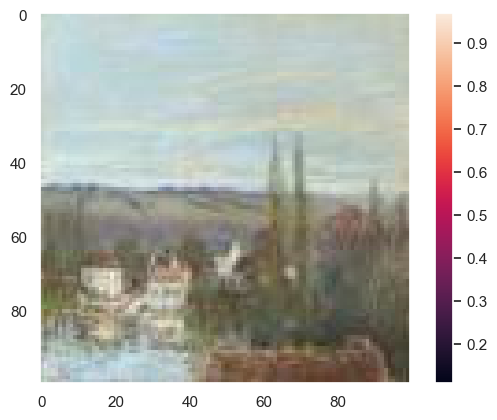

In [42]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

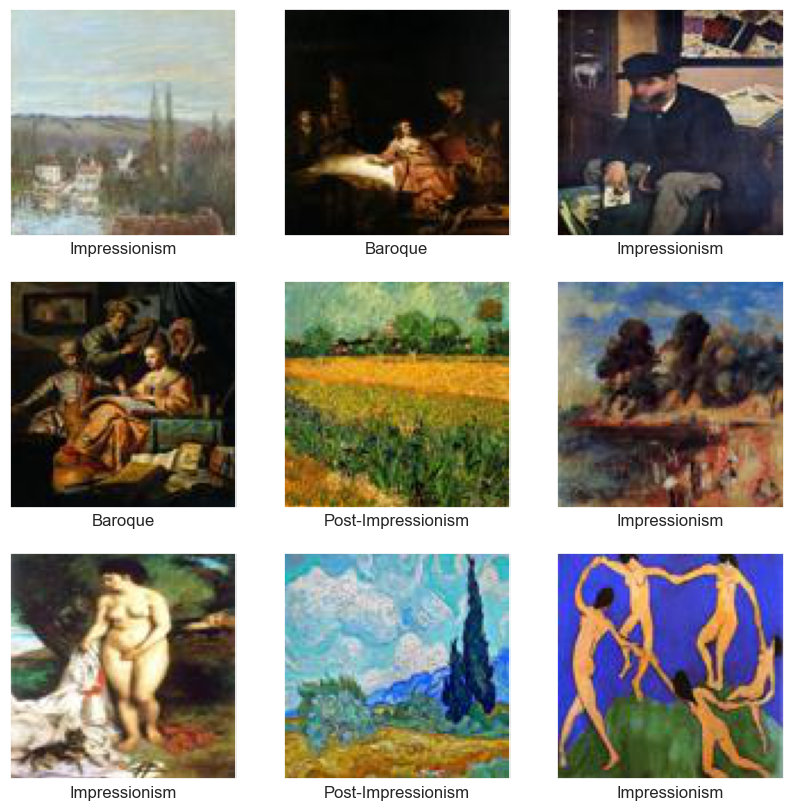

In [43]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [44]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
X_train.shape

(2679, 100, 100, 3)

In [45]:
print("We need to transform",round(((3821/5)/3),0),'every time')


We need to transform 255.0 every time


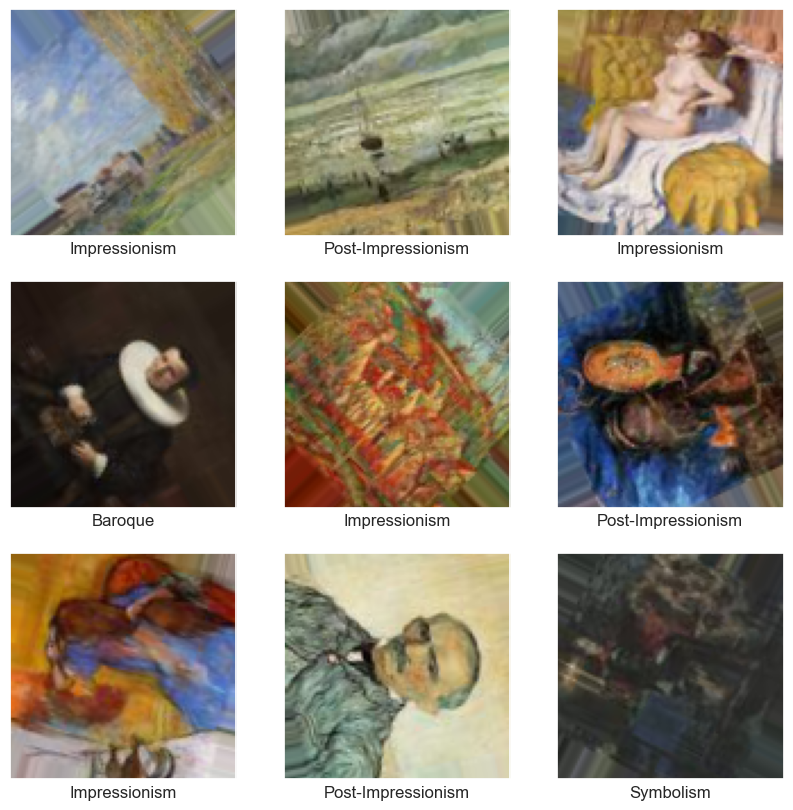

In [46]:
# define data preparation
datagen1 = ImageDataGenerator(rotation_range=90)
# configure batch size and retrieve one batch of images
plt.figure(figsize=(10,10))
plt.grid(False)
for X_batch1, y_batch1 in datagen1.flow(X_train, y_train, batch_size=500):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        #plt.subplot(330 + 1 + i)
        plt.imshow(X_batch1[i])
        plt.xlabel(class_names[y_batch1[i]])
# show the plot
    plt.show()
    break

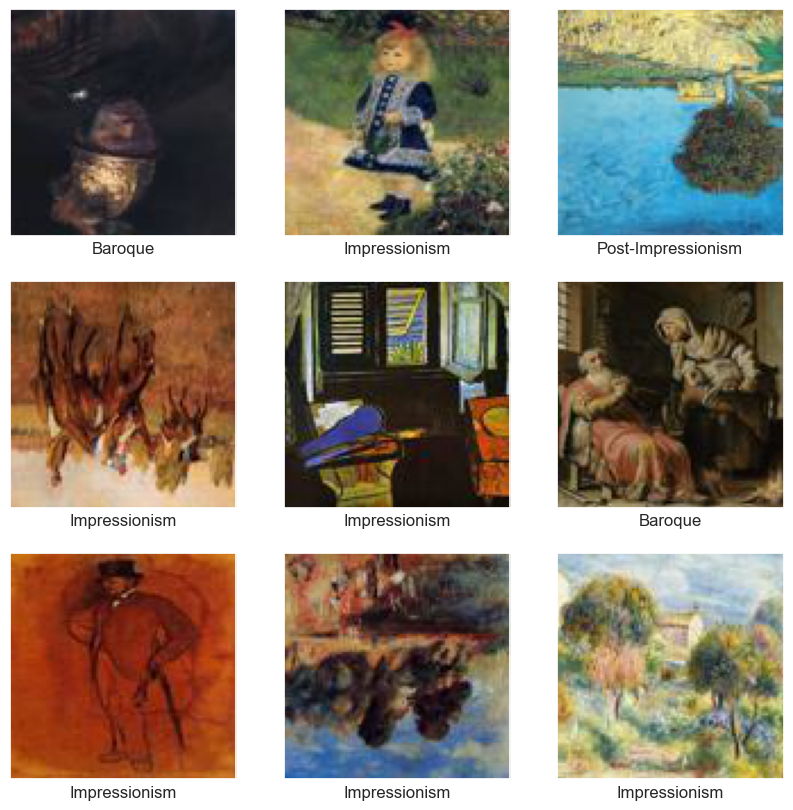

In [47]:
# define data preparation
datagen2 = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# fit parameters from data
#datagen2.fit(X_train)
# configure batch size and retrieve one batch of images
plt.figure(figsize=(10,10))
plt.grid(False)
for X_batch2, y_batch2 in datagen2.flow(X_train, y_train, batch_size=255):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_batch2[i])
        plt.xlabel(class_names[y_batch2[i]])
# show the plot
    plt.show()
    break

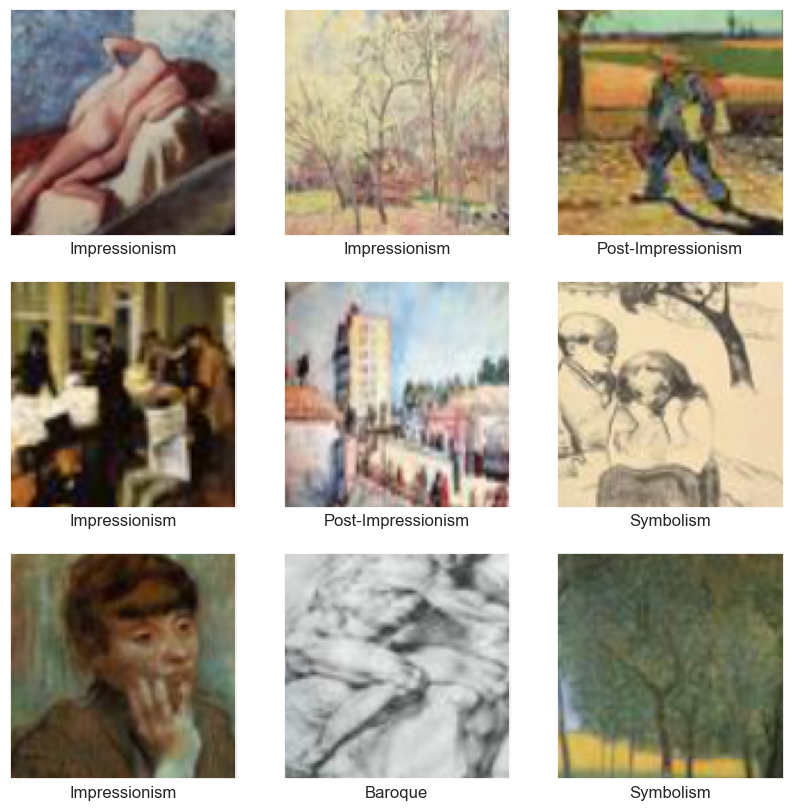

In [48]:
# define data preparation
datagen3 = ImageDataGenerator(zoom_range=[0.5,1.0])
# fit parameters from data
#datagen.fit(X_train)
# configure batch size and retrieve one batch of images
plt.figure(figsize=(10,10))
plt.grid(False)
for X_batch3, y_batch3 in datagen3.flow(X_train, y_train, batch_size=255):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_batch3[i])
        plt.xlabel(class_names[y_batch3[i]])
# show the plot
    plt.show()
    break

In [49]:
print(X_train.shape, X_batch1.shape)
print(y_train.shape,y_batch1.shape)

(2679, 100, 100, 3) (500, 100, 100, 3)
(2679,) (500,)


In [50]:
X_train2=np.append(X_train, X_batch1, axis=0)
X_train2=np.append(X_train2, X_batch2, axis=0)
X_train2=np.append(X_train2, X_batch3, axis=0)

In [51]:
y_train2=np.append(y_train, y_batch1, axis=0)
y_train2=np.append(y_train2, y_batch2, axis=0)
y_train2=np.append(y_train2, y_batch3, axis=0)

In [52]:
print(X_train2.shape,y_train2.shape)

(3689, 100, 100, 3) (3689,)


In [53]:
y_train2


array([0, 4, 0, ..., 0, 2, 3])

In [54]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(100,100,3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'), #activation: softmax, relu
    keras.layers.Dense(5)
])

2024-06-26 19:47:30.808615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
print(len(model.layers))


9


In [56]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [57]:
# optimizer="rmsprop", 'adam', opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model.fit(X_train2, y_train2, epochs=50, validation_split=0.2,shuffle=True,use_multiprocessing=True,workers=5) #adding validation


Epoch 1/50
93/93 [==============================] - 17s 177ms/step - loss: 1.1628 - accuracy: 0.4775 - val_loss: 1.0797 - val_accuracy: 0.5122
Epoch 2/50
93/93 [==============================] - 17s 179ms/step - loss: 1.0277 - accuracy: 0.5574 - val_loss: 1.0487 - val_accuracy: 0.5325
Epoch 3/50
93/93 [==============================] - 18s 190ms/step - loss: 0.9643 - accuracy: 0.5890 - val_loss: 1.0988 - val_accuracy: 0.5745
Epoch 4/50
93/93 [==============================] - 20s 219ms/step - loss: 0.9128 - accuracy: 0.6181 - val_loss: 1.0134 - val_accuracy: 0.5705
Epoch 5/50
93/93 [==============================] - 16s 176ms/step - loss: 0.8361 - accuracy: 0.6513 - val_loss: 0.9993 - val_accuracy: 0.6192
Epoch 6/50
93/93 [==============================] - 17s 179ms/step - loss: 0.7506 - accuracy: 0.6971 - val_loss: 0.9380 - val_accuracy: 0.6098
Epoch 7/50
93/93 [==============================] - 16s 171ms/step - loss: 0.6546 - accuracy: 0.7425 - val_loss: 1.2566 - val_accuracy: 0.5054

In [59]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

36/36 - 2s - loss: 3.8950 - accuracy: 0.6475 - 2s/epoch - 50ms/step

Test accuracy: 0.647519588470459


In [60]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [61]:
predictions = probability_model.predict(X_test)
predictions[0]

36/36 [==============================] - 2s 63ms/step


array([1.0000000e+00, 3.3064178e-38, 1.9592777e-17, 1.7350100e-09,
       4.8140845e-20], dtype=float32)

In [63]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

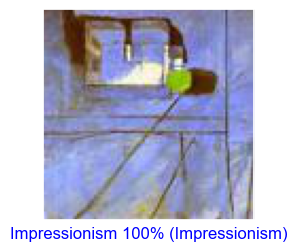

In [64]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
#plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  y_test)
plt.show()

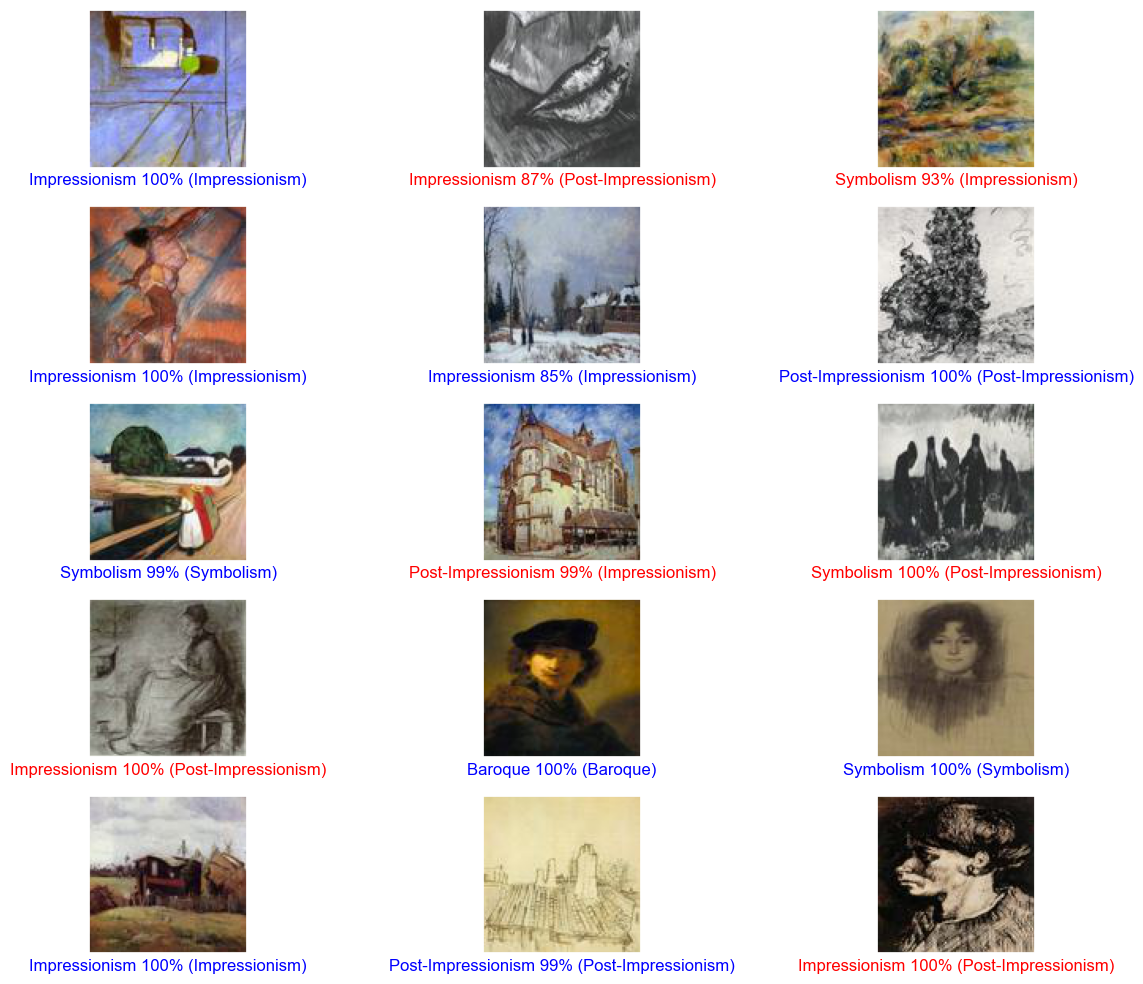

In [65]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, X_test)
    #plt.subplot(num_rows, 2*num_cols, 2*i+2)
    #plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [66]:
from sklearn.metrics import confusion_matrix
preds=model.predict(X_test)
from keras.utils import to_categorical
y_test2 = to_categorical(y_test)
preds.argmax(axis=1)

36/36 [==============================] - 2s 62ms/step


array([0, 0, 3, ..., 2, 3, 0])

In [67]:
to_categorical(preds.argmax(axis=1))

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [68]:
y_test

array([0, 2, 0, ..., 2, 3, 0])

In [69]:
y_test2

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [78]:
# creating confusion matrix
array=confusion_matrix(y_test, preds.argmax(axis=1),labels=[0,1,2,3,4])
dct_class

{'Impressionism': 0,
 'Renaissance': 1,
 'Post-Impressionism': 2,
 'Symbolism': 3,
 'Baroque': 4}

36/36 [==============================] - 2s 56ms/step


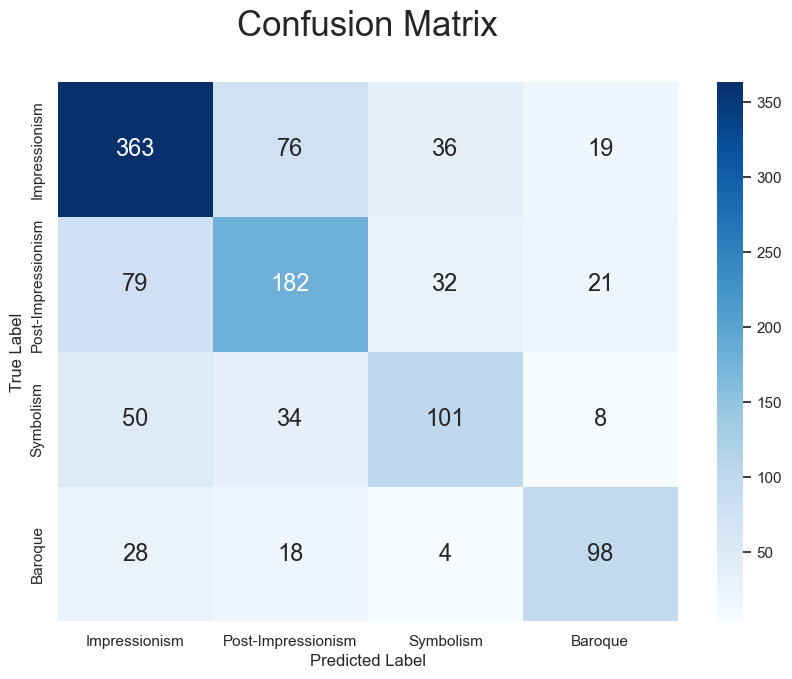

In [119]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical

# Predict the labels for the test set
preds = model.predict(X_test)

# Convert predictions to categorical
y_test2 = to_categorical(y_test)

# Convert predicted labels to categorical
preds_categorical = to_categorical(preds.argmax(axis=1))

# Remove Renaissance (label 1) from y_test and preds
mask = y_test != 1
y_test_filtered = y_test[mask]
preds_filtered = preds.argmax(axis=1)[mask]

# Creating confusion matrix excluding Renaissance
conf_matrix = confusion_matrix(y_test_filtered, preds_filtered, labels=[0, 2, 3, 4])

# Define class names excluding Renaissance
dct_class = {
    "Impressionism": 0,
    "Post-Impressionism": 2,
    "Symbolism": 3,
    "Baroque": 4
}

# Create DataFrame for confusion matrix
df_cm = pd.DataFrame(conf_matrix, index=[i for i in dct_class.keys()],
                     columns=[i for i in dct_class.keys()])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.title("Confusion Matrix" + "\n", fontsize=25)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 17}, cmap='Blues', fmt='g')  # font size
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [108]:
model.save('final_mini_project.ipynb')

INFO:tensorflow:Assets written to: final_mini_project.ipynb/assets


INFO:tensorflow:Assets written to: final_mini_project.ipynb/assets


In [86]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

Testing the model
Genre list:
['Impressionism', 'Post-Impressionism', 'Symbolism', 'Baroque']


Please enter an image URL to test the model:  https://listart.mit.edu/sites/default/files/styles/uncropped_100/public/media/images/2022-09/51194681324_86f26588ed_o.jpg.webp?itok=L6zh0DZr


/var/folders/y4/mrkhbvgd2pd_01y2n8j_52z80000gn/T/ipykernel_38118/3835218860.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  web_image = imageio.imread(url)


1/1 [==============================] - 0s 26ms/step
Predicted genre = Baroque
Prediction probability = (99.74538683891296, 2) %


/var/folders/y4/mrkhbvgd2pd_01y2n8j_52z80000gn/T/ipykernel_38118/3835218860.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread(url))


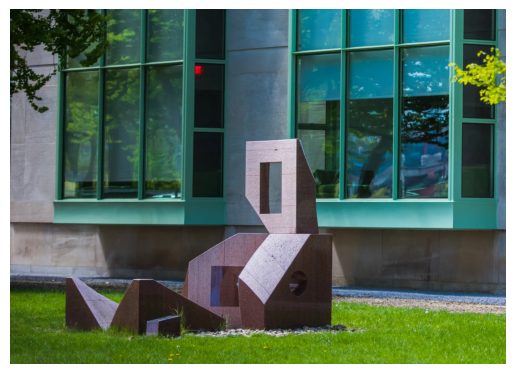

In [106]:
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Define the genre list
genre = ['Impressionism', 'Post-Impressionism', 'Symbolism', 'Baroque']

def transform_url(url):
    # Read and preprocess the image from the web
    web_image = imageio.imread(url)
    web_image = cv2.resize(web_image, dsize=(100,100))
    web_image = web_image / 255.0
    web_image = np.expand_dims(web_image, axis=0)
    return web_image

def predict_url(web_image):
    # Make predictions
    prediction = probability_model.predict(web_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)
    
    print("Predicted genre =", genre[prediction_idx])
    print("Prediction probability =", (((prediction_probability)*100), 2), "%")
    
    # Display the image
    plt.imshow(imageio.imread(url))
    plt.axis('off')
    plt.show()
    return prediction

# Testing the model
print("Testing the model")
print("Genre list:")
print(genre)
url = input("Please enter an image URL to test the model: ")
web_image = transform_url(url)
test_prediction = predict_url(web_image)